In [1]:
import pandas as pd

chunk_size = 1_000_000  # Number of rows per chunk
chunks = pd.read_csv('combined_wesad_data.csv', chunksize=chunk_size)

df = next(chunks)

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.preprocessing import MinMaxScaler


# Prepare data (reshaping for LSTM: [samples, timesteps, features])
X = df.drop(columns=['label', 'participant', 'time'])
y = df['label']

columns_to_scale = ['heart_rate', 'heart_rate_ma', 'accel_x', 'accel_y', 'accel_z', 'accel_magnitude', 'temperature']

scaler = MinMaxScaler()
X[columns_to_scale] = scaler.fit_transform(X[columns_to_scale])

# Chunk data into sequences (e.g., 10 time steps per sample)
def create_sequences(data, labels, sequence_length=10):
    X_seq, y_seq = [], []
    for i in range(len(data) - sequence_length):
        X_seq.append(data.iloc[i:i+sequence_length].values)
        y_seq.append(labels.iloc[i+sequence_length])  # Use label at the end of the sequence
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X, y, sequence_length=10)


/Users/ekanshsahu/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
# One-hot encode labels for classification
encoder = OneHotEncoder(sparse_output=False)
y_seq_encoded = encoder.fit_transform(y_seq.reshape(-1, 1))


In [5]:
import torch

In [6]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

chunk_size = 1_000_000  # Number of rows per chunk
chunks = pd.read_csv('combined_wesad_data.csv', chunksize=chunk_size)

df = next(chunks)

# Drop participant column and handle missing data
df = df.drop(columns=['participant']).dropna()

# Normalize the data (excluding the label)
scaler = StandardScaler()
features = df.drop(columns=['label']).values
labels = df['label'].values
features = scaler.fit_transform(features)

# 2. Create overlapping sequences (patches)
def create_sequences(data, labels, sequence_length=50):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])  # Create a sequence of 'sequence_length'
        y.append(labels[i+sequence_length])  # Label corresponds to the end of the sequence
    return np.array(X), np.array(y)

sequence_length = 50
X, y = create_sequences(features, labels, sequence_length)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42, stratify=y)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# 3. Create DataLoader
batch_size = 64
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 4. PatchTST Model Definition
class PatchTST(nn.Module):
    def __init__(self, input_dim, patch_size, d_model, n_heads, num_layers, num_classes, dropout=0.1):
        super(PatchTST, self).__init__()
        self.patch_size = patch_size
        self.embedding = nn.Linear(patch_size * input_dim, d_model)  # Patch embedding
        self.positional_encoding = nn.Parameter(torch.randn(1, 500, d_model))  # Positional encoding
        
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        
        self.fc = nn.Linear(d_model, num_classes)  # Output layer for classification

    def forward(self, x):
        B, T, D = x.shape  # Batch, Time, Features
        num_patches = T // self.patch_size
        x = x[:, :num_patches * self.patch_size, :]  # Ensure divisible by patch size
        x = x.view(B, num_patches, -1)  # Reshape into patches

        # Patch embedding and positional encoding
        x = self.embedding(x)
        x += self.positional_encoding[:, :x.size(1), :]  # Add positional encoding

        # Transformer Encoder
        x = self.transformer_encoder(x)

        # Classification token (use the mean of all tokens)
        x = x.mean(dim=1)  # Average across the sequence length
        out = self.fc(x)
        return out



In [ ]:
import sys
# 5. Initialize Model, Loss, and Optimizer
input_dim = X_train.shape[2]  # Number of features
patch_size = 10
d_model = 64
n_heads = 4
num_layers = 3
num_classes = len(np.unique(y))  # Number of unique labels (0-7)
dropout = 0.1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = PatchTST(input_dim, patch_size, d_model, n_heads, num_layers, num_classes, dropout).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 6. Training Loop
epochs = 5
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Print update every 10 batches
        if (batch_idx + 1) % 100 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item():.4f}")
            sys.stdout.flush()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss / len(train_loader):.4f}")

# 7. Evaluate Model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


ModuleNotFoundError: No module named 'plotly'

/Users/ekanshsahu/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/5, Batch 100/10937, Loss: 0.0885
Epoch 1/5, Batch 200/10937, Loss: 0.0091
Epoch 1/5, Batch 300/10937, Loss: 0.0139
Epoch 1/5, Batch 400/10937, Loss: 0.0069
Epoch 1/5, Batch 500/10937, Loss: 0.0181
Epoch 1/5, Batch 600/10937, Loss: 0.0215
Epoch 1/5, Batch 700/10937, Loss: 0.0006
Epoch 1/5, Batch 800/10937, Loss: 0.0172
Epoch 1/5, Batch 900/10937, Loss: 0.0170
Epoch 1/5, Batch 1000/10937, Loss: 0.0031
Epoch 1/5, Batch 1100/10937, Loss: 0.0099
Epoch 1/5, Batch 1200/10937, Loss: 0.0091
Epoch 1/5, Batch 1300/10937, Loss: 0.0112
Epoch 1/5, Batch 1400/10937, Loss: 0.0065
Epoch 1/5, Batch 1500/10937, Loss: 0.0163
Epoch 1/5, Batch 1600/10937, Loss: 0.0063
Epoch 1/5, Batch 1700/10937, Loss: 0.0222
Epoch 1/5, Batch 1800/10937, Loss: 0.0041
Epoch 1/5, Batch 1900/10937, Loss: 0.0194
Epoch 1/5, Batch 2000/10937, Loss: 0.0331
Epoch 1/5, Batch 2100/10937, Loss: 0.0132
Epoch 1/5, Batch 2200/10937, Loss: 0.0192
Epoch 1/5, Batch 2300/10937, Loss: 0.0058
Epoch 1/5, Batch 2400/10937, Loss: 0.0142
E

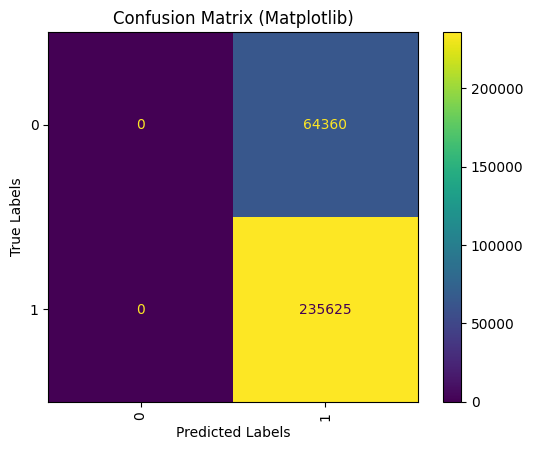

In [11]:
import sys
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# 5. Initialize Model, Loss, and Optimizer
input_dim = X_train.shape[2]  # Number of features
patch_size = 10
d_model = 64
n_heads = 4
num_layers = 3
num_classes = len(np.unique(y))  # Number of unique labels (0-7)
dropout = 0.1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = PatchTST(input_dim, patch_size, d_model, n_heads, num_layers, num_classes, dropout).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 6. Training Loop
epochs = 5
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Print update every 10 batches
        if (batch_idx + 1) % 100 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item():.4f}")
            sys.stdout.flush()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss / len(train_loader):.4f}")

# 7. Evaluate Model
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

# 8. Confusion Matrix and Visualization

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=np.unique(all_labels))

# Static confusion matrix (Matplotlib)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(all_labels))
disp.plot(cmap='viridis', xticks_rotation='vertical')
plt.title("Confusion Matrix (Matplotlib)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
